# 0

In [1]:
import os
import pandas as pd

# Step 1: Set Working Directory
working_directory = r"C:\...\code"
os.chdir(working_directory)

# Step 2: Load Dataset
file_path = "dataset_.xlsx"
sheet_name = "machine_learning"
usecols = "C:O"  # Columns from C to O
skiprows = 2  # Skip the first row
nrows = 42  # Number of rows to read

# Define the new headers
new_headers = ['PMCcode', 'city', 'tier_s', 'Prov', 'City_ave_price', 'Sales_absor_peri', 'Duration', 'Peak', 'Oppor', 'Oppor_percent', 'Peak_percent', 'PMC-I', 'PMC-T']

# Load the data
Neural_data = pd.read_excel(file_path, sheet_name=sheet_name, usecols=usecols, skiprows=skiprows, nrows=nrows, header=None)

# Set the new headers
Neural_data.columns = new_headers

# Map 'tier_s' to 'tier_sd' with the specified conditions
tier_map = {
    'Third Tier': -1,
    'Second Tier': 0,
    'First Tier': 1
}
Neural_data['tier_sd'] = Neural_data['tier_s'].map(tier_map)

# Display the first few rows of the dataframe to verify
print(Neural_data.tail())
Neural_data.head()



   PMCcode             city       tier_s       Prov  City_ave_price  \
36     P37        Zhongshan  Second Tier  Guangdong           13988   
37     P38         Zhongwei   Third Tier    Ningxia            4898   
38     P39           Zhuhai  Second Tier  Guangdong           26073   
39     P40  Tunchang County   Third Tier     Hainan            8395   
40     P41       Changjiang   Third Tier     Hainan            6880   

    Sales_absor_peri   Duration         Peak        Oppor  Oppor_percent  \
36              22.6  27.141667  3500.000000   336.375000       0.024047   
37              55.1  28.008333   978.711071    70.222186       0.014337   
38              55.7  27.141667  4000.000000  2174.610256       0.083405   
39              75.0  27.141667   761.146667    39.099713       0.004658   
40              18.1  27.141667  2508.729282   131.793812       0.019156   

    Peak_percent     PMC-I     PMC-T  tier_sd  
36      0.250214  7.716667  4.883333        0  
37      0.199819  6.

,PMCcode,city,tier_s,Prov,City_ave_price,Sales_absor_peri,Duration,Peak,Oppor,Oppor_percent,Peak_percent,PMC-I,PMC-T,tier_sd
0,P1,Baisha,Third Tier,Hainan,7850,109.100000,27.141667,3500.000000,44.559244,0.005676,0.445860,3.033333,3.033333,-1
1,P2,Beihai,Third Tier,Guangxi,6800,11.524897,27.141667,2560.107898,315.860994,0.046450,0.376486,3.416667,3.416667,-1
2,P3,Beijing,First Tier,Beijing,40094,19.000000,28.008333,5000.000000,1175.851697,0.029327,0.124707,6.916667,5.250000,1
3,P4,Chengmai,Third Tier,Hainan,11522,54.500000,27.141667,3500.000000,498.093750,0.043230,0.303767,4.350000,3.816667,-1
4,P5,Danzhou,Third Tier,Hainan,10533,82.500000,27.141667,1798.109091,84.611564,0.008033,0.170712,3.750000,2.883333,-1


PMC-T Optimization

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 数据标准化
scaler = StandardScaler()

X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd']]
y_pmct = Neural_data['PMC-T']
y_pmci = Neural_data['PMC-I']
y_tier_sd = Neural_data['tier_sd']

# 对分类变量进行OneHot编码
encoder = OneHotEncoder(sparse_output=False)
X_tier_sd_encoded = encoder.fit_transform(X[['tier_sd']])
X_other = X[['City_ave_price', 'Sales_absor_peri', 'Duration']]

# 合并OneHot编码后的分类变量和其他变量
X_combined = np.hstack((X_other, X_tier_sd_encoded))

# 标准化其他特征
X_combined_scaled = scaler.fit_transform(X_combined)

# 划分数据集
X_train_pmct, X_test_pmct, y_train_pmct, y_test_pmct = train_test_split(X_combined_scaled, y_pmct, test_size=0.3, random_state=42)
X_train_pmci, X_test_pmci, y_train_pmci, y_test_pmci = train_test_split(X_combined_scaled, y_pmci, test_size=0.3, random_state=42)

# 定义神经网络模型创建函数
def create_bpnn(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_dim=X_combined_scaled.shape[1]))
    model.add(Dense(24))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'prelu':
        model.add(PReLU())
    else:
        model.add(Dense(24, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 使用 KerasRegressor 包装模型
model_pmct = KerasRegressor(build_fn=create_bpnn, verbose=0)

# 定义网格搜索的参数
batch_size = [16, 32, 64]
epochs = [100, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# 进行批量大小的网格搜索
grid_pmct = GridSearchCV(estimator=model_pmct, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_pmct = grid_pmct.fit(X_train_pmct, y_train_pmct)

# 输出最优参数
print(f"Best batch size and epochs for PMC-T: {grid_result_pmct.best_params_}")

# 使用最优批量大小进行激活函数的网格搜索
best_batch_size_pmct = grid_result_pmct.best_params_['batch_size']
best_epochs_pmct = grid_result_pmct.best_params_['epochs']

activations = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'prelu']
param_grid = dict(batch_size=[best_batch_size_pmct], epochs=[best_epochs_pmct], activation=activations)

# 进行激活函数的网格搜索
grid_pmct_activation = GridSearchCV(estimator=model_pmct, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_pmct_activation = grid_pmct_activation.fit(X_train_pmct, y_train_pmct)

# 输出最优参数
print(f"Best activation function for PMC-T: {grid_result_pmct_activation.best_params_}")

# 可以同样的方式优化 PMC-I 和 tier_sd


c:\Users\Eric\.conda\envs\lymai3.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Eric\AppData\Local\Temp\ipykernel_20596\1689405209.py:51: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_pmct = KerasRegressor(build_fn=create_bpnn, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best batch size and epochs for PMC-T: {'batch_size': 16, 'epochs': 100}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best activation function for PMC-T: {'activation': 'relu', 'batch_size': 16, 'epochs': 100}


PMC-I optimization

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 数据标准化
scaler = StandardScaler()

X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd']]
y_pmct = Neural_data['PMC-T']
y_pmci = Neural_data['PMC-I']
y_tier_sd = Neural_data['tier_sd']

# 对分类变量进行OneHot编码
encoder = OneHotEncoder(sparse_output=False)
X_tier_sd_encoded = encoder.fit_transform(X[['tier_sd']])
X_other = X[['City_ave_price', 'Sales_absor_peri', 'Duration']]

# 合并OneHot编码后的分类变量和其他变量
X_combined = np.hstack((X_other, X_tier_sd_encoded))

# 标准化其他特征
X_combined_scaled = scaler.fit_transform(X_combined)

# 划分数据集
X_train_pmct, X_test_pmct, y_train_pmct, y_test_pmct = train_test_split(X_combined_scaled, y_pmct, test_size=0.3, random_state=42)
X_train_pmci, X_test_pmci, y_train_pmci, y_test_pmci = train_test_split(X_combined_scaled, y_pmci, test_size=0.3, random_state=42)

# 定义神经网络模型创建函数
def create_bpnn(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_dim=X_combined_scaled.shape[1]))
    model.add(Dense(24))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'prelu':
        model.add(PReLU())
    else:
        model.add(Dense(24, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 使用 KerasRegressor 包装模型
model_pmci = KerasRegressor(build_fn=create_bpnn, verbose=0)

# 定义网格搜索的参数
batch_size = [16, 32, 64]
epochs = [100, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# 进行批量大小的网格搜索
grid_pmci = GridSearchCV(estimator=model_pmci, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_pmci = grid_pmci.fit(X_train_pmci, y_train_pmci)

# 输出最优参数
print(f"Best batch size and epochs for PMC-I: {grid_result_pmci.best_params_}")

# 使用最优批量大小进行激活函数的网格搜索
best_batch_size_pmci = grid_result_pmci.best_params_['batch_size']
best_epochs_pmci = grid_result_pmci.best_params_['epochs']

activations = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'prelu']
param_grid = dict(batch_size=[best_batch_size_pmci], epochs=[best_epochs_pmci], activation=activations)

# 进行激活函数的网格搜索
grid_pmci_activation = GridSearchCV(estimator=model_pmci, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_pmci_activation = grid_pmci_activation.fit(X_train_pmci, y_train_pmci)

# 输出最优参数
print(f"Best activation function for PMC-I: {grid_result_pmci_activation.best_params_}")


C:\Users\Eric\AppData\Local\Temp\ipykernel_20596\3071753528.py:51: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_pmci = KerasRegressor(build_fn=create_bpnn, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best batch size and epochs for PMC-I: {'batch_size': 16, 'epochs': 100}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best activation function for PMC-I: {'activation': 'relu', 'batch_size': 16, 'epochs': 100}


tier_sd optimization

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 数据标准化
scaler = StandardScaler()

X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd']]
y_pmct = Neural_data['PMC-T']
y_pmci = Neural_data['PMC-I']
y_tier_sd = Neural_data['tier_sd']

# 对分类变量进行OneHot编码
encoder = OneHotEncoder(sparse_output=False)
X_tier_sd_encoded = encoder.fit_transform(X[['tier_sd']])
X_other = X[['City_ave_price', 'Sales_absor_peri', 'Duration']]

# 合并OneHot编码后的分类变量和其他变量
X_combined = np.hstack((X_other, X_tier_sd_encoded))

# 标准化其他特征
X_combined_scaled = scaler.fit_transform(X_combined)

# 独热编码标签
y_tier_sd_encoded = encoder.fit_transform(y_tier_sd.values.reshape(-1, 1))

# 划分数据集
X_train_tier_sd, X_test_tier_sd, y_train_tier_sd, y_test_tier_sd = train_test_split(X_combined_scaled, y_tier_sd_encoded, test_size=0.3, random_state=42)

# 定义神经网络模型创建函数
def create_bpnn_tier_sd(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_dim=X_combined_scaled.shape[1]))
    model.add(Dense(24))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    elif activation == 'prelu':
        model.add(PReLU())
    else:
        model.add(Dense(24, activation=activation))
    model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 使用 KerasClassifier 包装模型
model_tier_sd = KerasClassifier(build_fn=create_bpnn_tier_sd, verbose=0)

# 定义网格搜索的参数
batch_size = [16, 32, 64]
epochs = [100, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# 进行批量大小的网格搜索
grid_tier_sd = GridSearchCV(estimator=model_tier_sd, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_tier_sd = grid_tier_sd.fit(X_train_tier_sd, y_train_tier_sd)

# 输出最优参数
print(f"Best batch size and epochs for tier_sd: {grid_result_tier_sd.best_params_}")

# 使用最优批量大小进行激活函数的网格搜索
best_batch_size_tier_sd = grid_result_tier_sd.best_params_['batch_size']
best_epochs_tier_sd = grid_result_tier_sd.best_params_['epochs']

activations = ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'prelu']
param_grid = dict(batch_size=[best_batch_size_tier_sd], epochs=[best_epochs_tier_sd], activation=activations)

# 进行激活函数的网格搜索
grid_tier_sd_activation = GridSearchCV(estimator=model_tier_sd, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result_tier_sd_activation = grid_tier_sd_activation.fit(X_train_tier_sd, y_train_tier_sd)

# 输出最优参数
print(f"Best activation function for tier_sd: {grid_result_tier_sd_activation.best_params_}")


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\460618130.py:52: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_tier_sd = KerasClassifier(build_fn=create_bpnn_tier_sd, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best batch size and epochs for tier_sd: {'batch_size': 16, 'epochs': 200}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best activation function for tier_sd: {'activation': 'relu', 'batch_size': 16, 'epochs': 200}


# 1. 优化

## Original model

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pyswarm import pso
import numpy as np

# 选择相关列（去除 PMC-T 和 PMC-I）
X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd']]
y_pmct = Neural_data['PMC-T']
y_pmci = Neural_data['PMC-I']

# 划分 PMC-T 和 PMC-I 的训练集和测试集
X_train_pmct, X_test_pmct, y_train_pmct, y_test_pmct = train_test_split(X, y_pmct, test_size=0.3, random_state=42)
X_train_pmci, X_test_pmci, y_train_pmci, y_test_pmci = train_test_split(X, y_pmci, test_size=0.3, random_state=42)

# 定义 BP 神经网络模型以预测 PMC-T
def create_bpnn_pmct():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(20, activation='relu'))  # 增加层数和神经元数量
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 定义 BP 神经网络模型以预测 PMC-I
def create_bpnn_pmci():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(20, activation='relu'))  # 增加层数和神经元数量
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 训练模型
bpnn_model_pmct = create_bpnn_pmct()
bpnn_model_pmct.fit(X_train_pmct, y_train_pmct, epochs=100, batch_size=10, verbose=0)

bpnn_model_pmci = create_bpnn_pmci()
bpnn_model_pmci.fit(X_train_pmci, y_train_pmci, epochs=100, batch_size=10, verbose=0)

# 预测 PMC-T 和 PMC-I
y_pred_pmct = bpnn_model_pmct.predict(X_test_pmct)
y_pred_pmci = bpnn_model_pmci.predict(X_test_pmci)

# 将预测的 PMC-T 和 PMC-I 添加到训练和测试数据集中
X_train_opp_peak = X_train_pmct.copy()
X_test_opp_peak = X_test_pmct.copy()
X_train_opp_peak['PMC-T'] = bpnn_model_pmct.predict(X_train_pmct)
X_test_opp_peak['PMC-T'] = y_pred_pmct
X_train_opp_peak['PMC-I'] = bpnn_model_pmci.predict(X_train_pmci)
X_test_opp_peak['PMC-I'] = y_pred_pmci

# 目标变量
y_opp = Neural_data['Oppor']
y_peak = Neural_data['Peak']

# 划分 Oppor 和 Peak 数据集
y_train_opp, y_test_opp = train_test_split(y_opp, test_size=0.3, random_state=42)
y_train_peak, y_test_peak = train_test_split(y_peak, test_size=0.3, random_state=42)

# 将训练集和测试集整合到一个完整的特征集和目标集
X_train = X_train_opp_peak
X_test = X_test_opp_peak
y_train = np.column_stack((y_train_peak, y_train_opp))
y_test = np.column_stack((y_test_peak, y_test_opp))

# 定义 BP 神经网络模型
def create_bpnn():
    model = Sequential()
    model.add(Dense(6, input_dim=6, activation='relu'))  # 输入维度为6，包括PMC-T和PMC-I
    model.add(Dense(20, activation='relu'))  # 增加层数和神经元数量
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='linear'))  # 输出为2，对应 'Peak' 和 'Oppor'
    return model

bpnn_model = create_bpnn()

# PSO 优化设置
def evaluate(weights):
    start = 0
    for layer in bpnn_model.layers:
        end = start + layer.get_weights()[0].size
        weight_array = np.array(weights[start:end]).reshape(layer.get_weights()[0].shape)
        bias_array = np.array(weights[end:end + layer.get_weights()[1].size]).reshape(layer.get_weights()[1].shape)
        layer.set_weights([weight_array, bias_array])
        start = end + layer.get_weights()[1].size
    
    y_pred = bpnn_model.predict(X_train_opp_peak)
    mse = mean_squared_error(y_train, y_pred)
    return mse

# 获取模型的权重维数
num_weights = sum([layer.get_weights()[0].size + layer.get_weights()[1].size for layer in bpnn_model.layers])

# PSO 参数设置
lb = [-1] * num_weights  # 下界
ub = [1] * num_weights   # 上界

# 运行 PSO
best_weights, best_mse = pso(evaluate, lb, ub, swarmsize=45, maxiter=100)

# 设置最佳权重
start = 0
for layer in bpnn_model.layers:
    end = start + layer.get_weights()[0].size
    weight_array = np.array(best_weights[start:end]).reshape(layer.get_weights()[0].shape)
    bias_array = np.array(best_weights[end:end + layer.get_weights()[1].size]).reshape(layer.get_weights()[1].shape)
    layer.set_weights([weight_array, bias_array])
    start = end + layer.get_weights()[1].size

# 在测试集上进行预测
y_pred = bpnn_model.predict(X_test_opp_peak)

# 计算 'Oppor' 的性能指标
mse_opp = mean_squared_error(y_test_opp, y_pred[:, 1])
mape_opp = mean_absolute_percentage_error(y_test_opp, y_pred[:, 1])
r2_opp = r2_score(y_test_opp, y_pred[:, 1])

# 计算 'Peak' 的性能指标
mse_peak = mean_squared_error(y_test_peak, y_pred[:, 0])
mape_peak = mean_absolute_percentage_error(y_test_peak, y_pred[:, 0])
r2_peak = r2_score(y_test_peak, y_pred[:, 0])




1/1 [==============================] - 0s 16ms/step
Stopping search: maximum iterations reached --> 100
1/1 [==============================] - 0s 20ms/step


## Optimized model

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pyswarm import pso
import numpy as np

# 选择相关列（去除 PMC-T 和 PMC-I）
X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd']]
y_pmct = Neural_data['PMC-T']
y_pmci = Neural_data['PMC-I']

# 划分 PMC-T 和 PMC-I 的训练集和测试集
X_train_pmct, X_test_pmct, y_train_pmct, y_test_pmct = train_test_split(X, y_pmct, test_size=0.3, random_state=42)
X_train_pmci, X_test_pmci, y_train_pmci, y_test_pmci = train_test_split(X, y_pmci, test_size=0.3, random_state=42)

# 定义 BP 神经网络模型以预测 PMC-T
def create_bpnn_pmct():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 定义 BP 神经网络模型以预测 PMC-I
def create_bpnn_pmci():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 训练模型
bpnn_model_pmct = create_bpnn_pmct()
bpnn_model_pmct.fit(X_train_pmct, y_train_pmct, epochs=100, batch_size=10, verbose=0)

bpnn_model_pmci = create_bpnn_pmci()
bpnn_model_pmci.fit(X_train_pmci, y_train_pmci, epochs=100, batch_size=10, verbose=0)

# 预测 PMC-T 和 PMC-I
y_pred_pmct = bpnn_model_pmct.predict(X_test_pmct)
y_pred_pmci = bpnn_model_pmci.predict(X_test_pmci)

# 将预测的 PMC-T 和 PMC-I 添加到训练和测试数据集中
X_train_opp_peak = X_train_pmct.copy()
X_test_opp_peak = X_test_pmct.copy()
X_train_opp_peak['PMC-T'] = bpnn_model_pmct.predict(X_train_pmct)
X_test_opp_peak['PMC-T'] = y_pred_pmct
X_train_opp_peak['PMC-I'] = bpnn_model_pmci.predict(X_train_pmci)
X_test_opp_peak['PMC-I'] = y_pred_pmci

# 目标变量
y_opp = Neural_data['Oppor']
y_peak = Neural_data['Peak']

# 划分 Oppor 和 Peak 数据集
y_train_opp, y_test_opp = train_test_split(y_opp, test_size=0.3, random_state=42)
y_train_peak, y_test_peak = train_test_split(y_peak, test_size=0.3, random_state=42)

# 将训练集和测试集整合到一个完整的特征集和目标集
X_train = X_train_opp_peak
X_test = X_test_opp_peak
y_train = np.column_stack((y_train_peak, y_train_opp))
y_test = np.column_stack((y_test_peak, y_test_opp))

# 定义 BP 神经网络模型
def create_bpnn():
    model = Sequential()
    model.add(Dense(6, input_dim=6, activation='relu'))  # 输入维度为6，包括PMC-T和PMC-I
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='linear'))  # 输出为2，对应 'Peak' 和 'Oppor'
    return model

bpnn_model = create_bpnn()

# PSO 优化设置
def evaluate(weights):
    start = 0
    for layer in bpnn_model.layers:
        end = start + layer.get_weights()[0].size
        weight_array = np.array(weights[start:end]).reshape(layer.get_weights()[0].shape)
        bias_array = np.array(weights[end:end + layer.get_weights()[1].size]).reshape(layer.get_weights()[1].shape)
        layer.set_weights([weight_array, bias_array])
        start = end + layer.get_weights()[1].size
    
    y_pred = bpnn_model.predict(X_train_opp_peak)
    mse = mean_squared_error(y_train, y_pred)
    return mse

# 获取模型的权重维数
num_weights = sum([layer.get_weights()[0].size + layer.get_weights()[1].size for layer in bpnn_model.layers])

# PSO 参数设置
lb = [-1] * num_weights  # 下界
ub = [1] * num_weights   # 上界

# 运行 PSO
best_weights, best_mse = pso(evaluate, lb, ub, swarmsize=45, maxiter=100)

# 设置最佳权重
start = 0
for layer in bpnn_model.layers:
    end = start + layer.get_weights()[0].size
    weight_array = np.array(best_weights[start:end]).reshape(layer.get_weights()[0].shape)
    bias_array = np.array(best_weights[end:end + layer.get_weights()[1].size]).reshape(layer.get_weights()[1].shape)
    layer.set_weights([weight_array, bias_array])
    start = end + layer.get_weights()[1].size

# 在测试集上进行预测
y_pred = bpnn_model.predict(X_test_opp_peak)

# 计算 'Oppor' 的性能指标
mse_opp = mean_squared_error(y_test_opp, y_pred[:, 1])
mape_opp = mean_absolute_percentage_error(y_test_opp, y_pred[:, 1])
r2_opp = r2_score(y_test_opp, y_pred[:, 1])

# 计算 'Peak' 的性能指标
mse_peak = mean_squared_error(y_test_peak, y_pred[:, 0])
mape_peak = mean_absolute_percentage_error(y_test_peak, y_pred[:, 0])
r2_peak = r2_score(y_test_peak, y_pred[:, 0])


1/1 [==============================] - 0s 24ms/step
Stopping search: maximum iterations reached --> 100
1/1 [==============================] - 0s 21ms/step


In [77]:
# 打印结果
print(f"Model Performance for 'Oppor':")
print(f"MSE: {mse_opp}")
print(f"MAPE: {mape_opp}")
print(f"R-squared: {r2_opp}")

print(f"\nModel Performance for 'Peak':")
print(f"MSE: {mse_peak}")
print(f"MAPE: {mape_peak}")
print(f"R-squared: {r2_peak}")

Model Performance for 'Oppor':
MSE: 177539.90862878438
MAPE: 1.991390945028523
R-squared: 0.5949442489645631

Model Performance for 'Peak':
MSE: 34728926.88973538
MAPE: 0.7146048404691671
R-squared: 0.5559431105907935


# 2. SHAP value explainabiltiy 

1/1 [==============================] - 0s 66ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

55/55 [==============================] - 0s 1ms/step


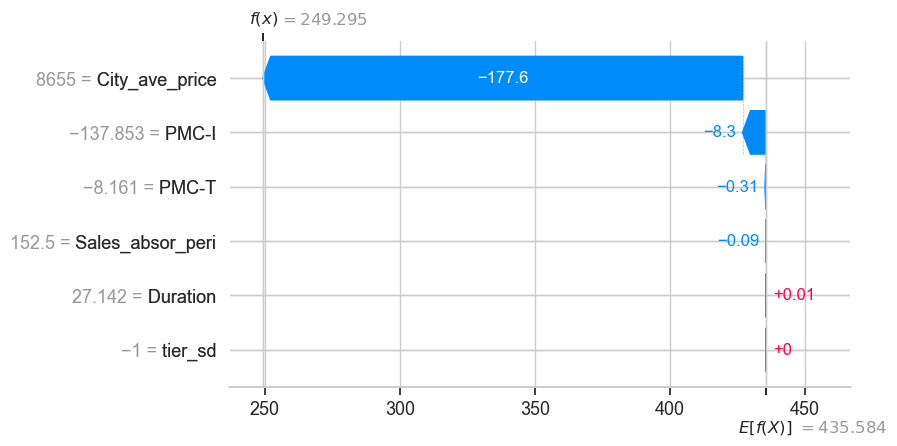

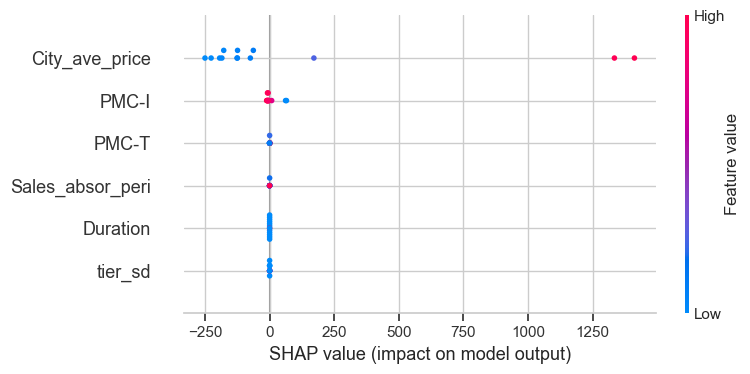

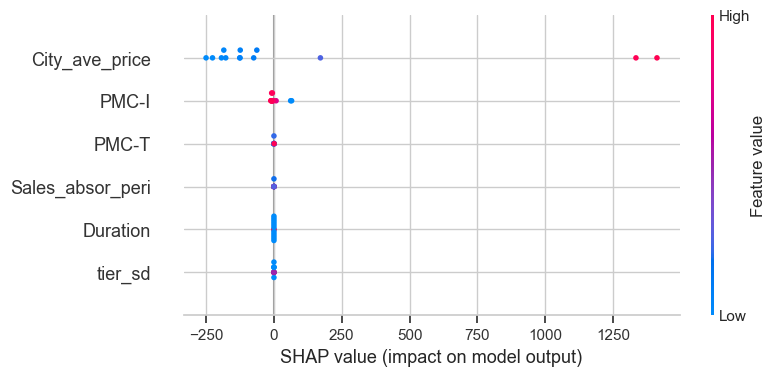

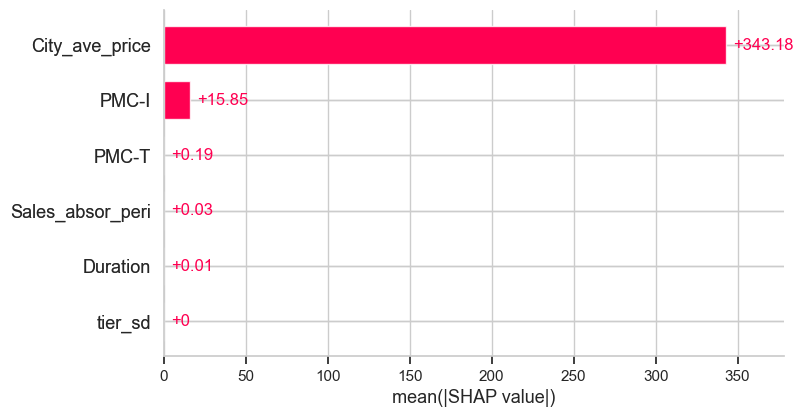

c:\Users\Eric\.conda\envs\lymai3.9\lib\site-packages\shap\utils\_clustering.py:126: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
c:\Users\Eric\.conda\envs\lymai3.9\lib\site-packages\shap\utils\_clustering.py:126: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")


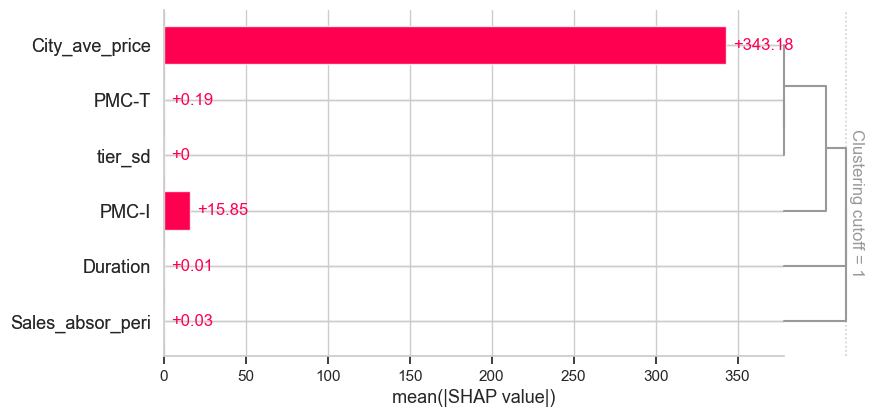

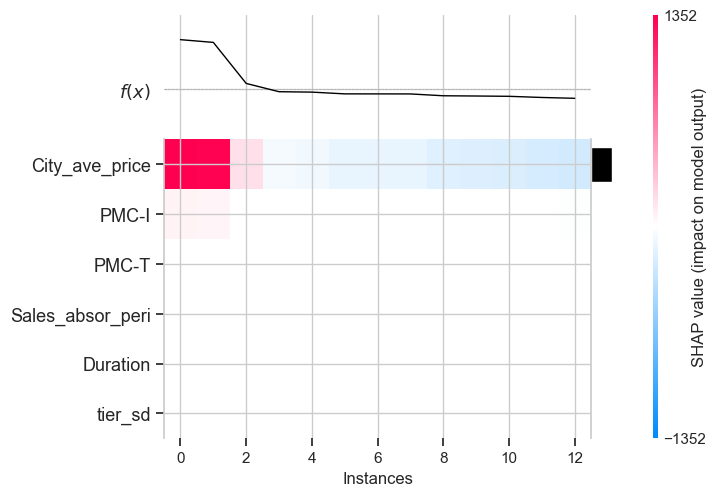

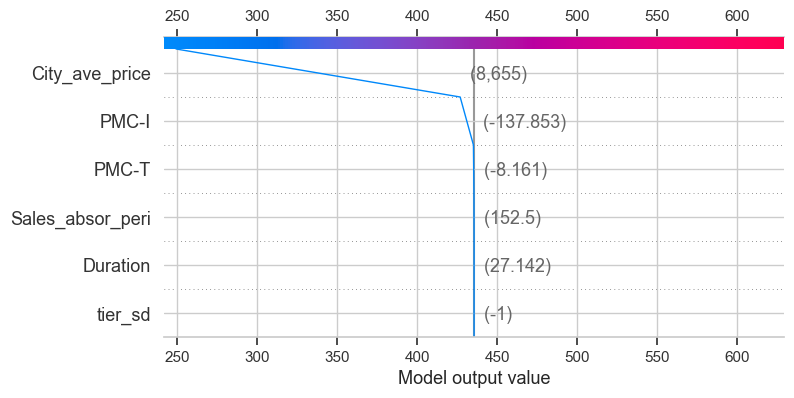

In [78]:
import shap
import numpy as np

# 初始化JavaScript可视化
shap.initjs()

# 使用SHAP解释模型预测，针对 'Oppor'
# 由于bpnn_model.predict返回两个输出（'Peak' 和 'Oppor'），需要包装一下以确保只解释 'Oppor'
def predict_opp(data):
    return bpnn_model.predict(data)[:, 1]  # 选择第二个输出 'Oppor'

explainer_opp = shap.KernelExplainer(predict_opp, X_train)
shap_values_opp = explainer_opp.shap_values(X_test, nsamples=100)

# 获取 'Oppor' 的 SHAP 值
shap_values_opp_output = np.array(shap_values_opp)

# 检查 expected_value 是否是数组
if np.isscalar(explainer_opp.expected_value):
    expected_value_opp = np.full(shap_values_opp_output.shape[0], explainer_opp.expected_value)
else:
    expected_value_opp = explainer_opp.expected_value

# 将 SHAP 值封装为 Explanation 对象
shap_exp_opp = shap.Explanation(values=shap_values_opp_output, 
                                base_values=expected_value_opp, 
                                data=X_test, 
                                feature_names=X_test.columns)

# 可视化第一个预测值的解释，针对 'Oppor'
shap.plots.waterfall(shap_exp_opp[0])

# 生成 SHAP summary plot
shap.summary_plot(shap_exp_opp.values, X_test, feature_names=X_test.columns)

# 生成 SHAP beeswarm plot
shap.plots.beeswarm(shap_exp_opp)

# 生成 SHAP bar plot
shap.plots.bar(shap_exp_opp)

# 生成层次聚类 + SHAP值
# 请注意，这里我假设 y_test_opp 为分类标签
# 如果 y_test_opp 是回归值，请根据实际数据调整

# 将 y_test_opp 转换为整型标签
y_test_opp_labels = (y_test_opp > y_test_opp.mean()).astype(int)

# 生成层次聚类
clust = shap.utils.hclust(X_test, y_test_opp_labels, linkage="single")

# 生成 SHAP bar plot with clustering
shap.plots.bar(shap_exp_opp, clustering=clust, clustering_cutoff=1)

# 生成 SHAP 热力图 (heatmap)
shap.plots.heatmap(shap_exp_opp)

# 生成决策图
select = range(min(1, len(X_test)))  # 确保选择的范围不会超出 X_test 的大小
features = X_test.iloc[select]
shap_values_select = shap_values_opp_output[select]

shap.decision_plot(expected_value_opp[:len(shap_values_select)], shap_values_select, features)


In [79]:
# 可视化第一个预测值的解释，生成force plot
shap.initjs()
shap.plots.force(explainer_opp.expected_value, shap_values_opp_output[0:1])

In [80]:
# 生成 SHAP force plot
shap.initjs()
shap.force_plot(explainer_opp.expected_value, shap_values_opp_output[0:41], X_test[0:41])

## PDP 和 ICE 图

4/4 [==============================] - 0s 3ms/step


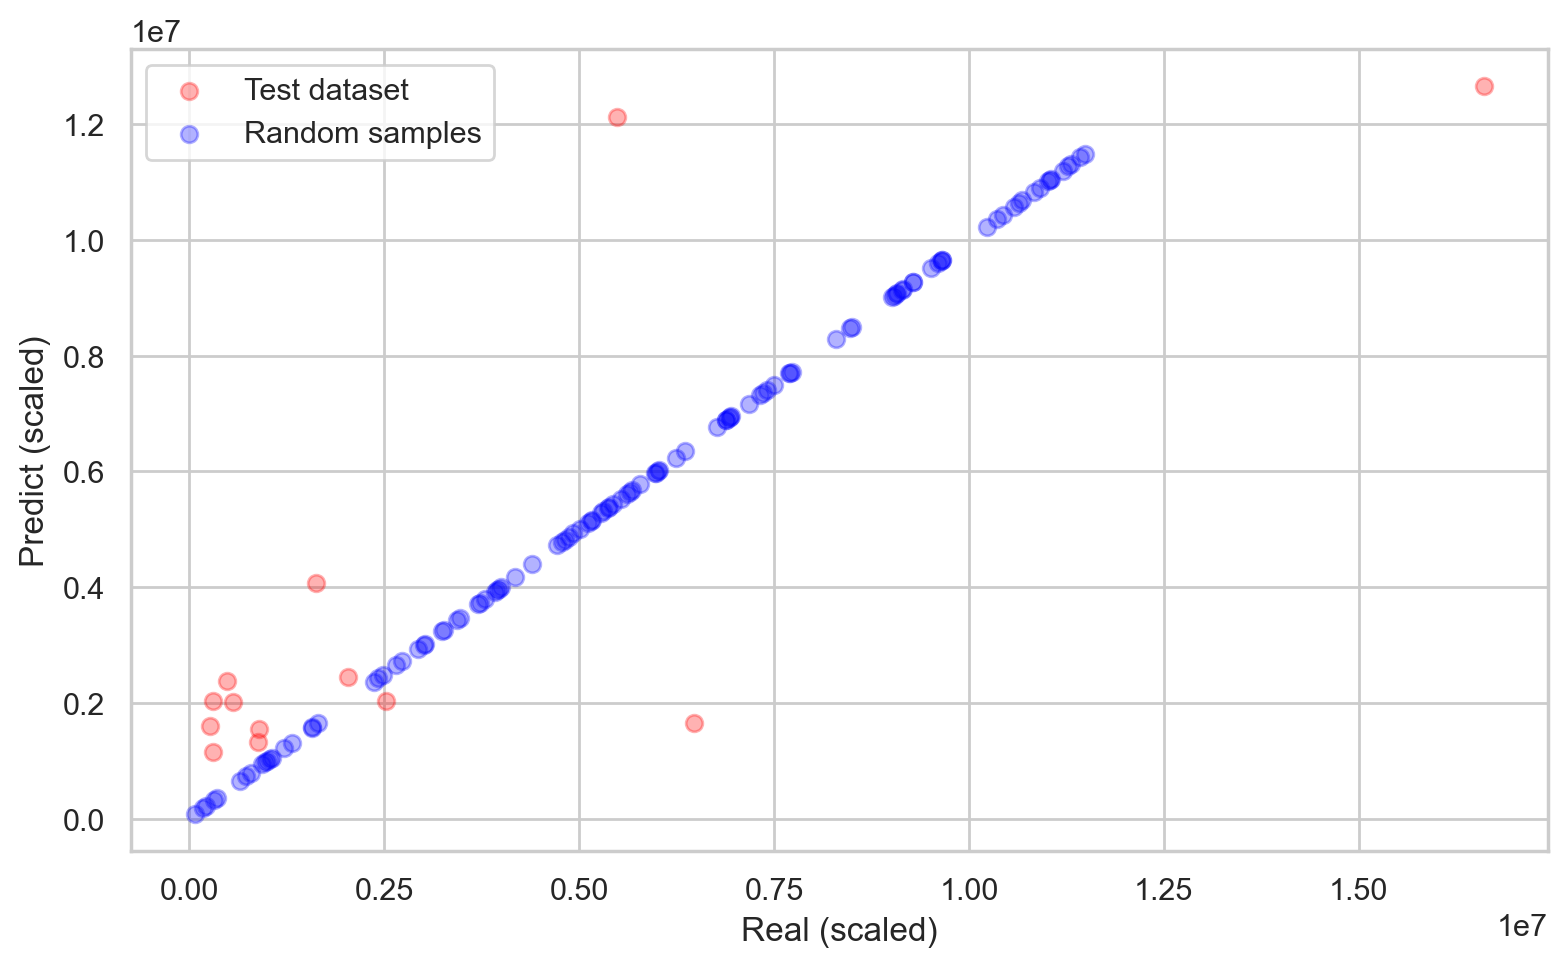

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 预测函数
def acc(model, X):
    predictions = model.predict(X)
    return predictions

# 获取测试集的预测值
test_pred = acc(bpnn_model, X_test)

# 假设 y_test 需要标准化还原
y_std = np.std(y_test, axis=0)
y_mean = np.mean(y_test, axis=0)

# 还原真实值和预测值
y_test_h = y_test * y_std + y_mean
pred_test_h = test_pred * y_std + y_mean

# 仅取 'Oppor' 列进行评价和可视化
y_test_h_opp = y_test_h[:, 1]
pred_test_h_opp = pred_test_h[:, 1]

# 放大预测值和真实值
scale_factor = 10
y_test_h_opp_scaled = y_test_h_opp * scale_factor
pred_test_h_opp_scaled = pred_test_h_opp * scale_factor

# 生成随机解释变量
num_random_samples = 110
max_values = X_test.max(axis=0).to_numpy()
random_X = np.random.rand(num_random_samples, X_test.shape[1]) * max_values

# 使用模型预测这些随机解释变量的目标值
random_pred = acc(bpnn_model, random_X)

# 还原预测值
random_pred_h = random_pred * y_std + y_mean
random_pred_h_opp = random_pred_h[:, 1]

# 放大预测值
random_pred_h_opp_scaled = random_pred_h_opp * scale_factor

# 绘制放大后的预测值和真实值的散点图
plt.figure(figsize=(8, 5), dpi=200)
plt.scatter(y_test_h_opp_scaled, pred_test_h_opp_scaled, label='Test dataset', alpha=0.3, color='red')
plt.scatter(random_pred_h_opp_scaled, random_pred_h_opp_scaled, label='Random samples', alpha=0.3, color='blue')
plt.xlabel('Real (scaled)')
plt.ylabel('Predict (scaled)')
plt.legend()
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\3185074221.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx] = value


1/1 [==============================] - 0s 21ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\3185074221.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx] = value


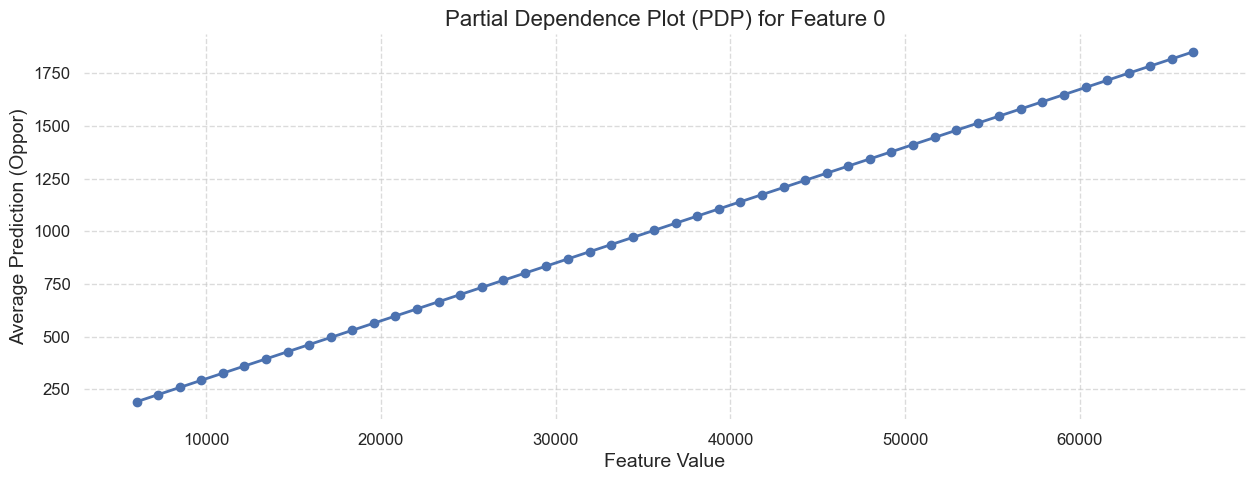

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义部分依赖函数
def partial_dependence(model, feature_idx, feature_values, dataset):
    predictions = []
    for value in feature_values:
        # 复制数据集并修改当前特征的值
        modified_dataset = dataset.copy()
        modified_dataset.iloc[:, feature_idx] = value
        # 使用模型进行预测
        predict = model.predict(modified_dataset)
        # 获取预测的平均值
        mean_predict = np.mean(predict[:, 1])  # 针对 'Oppor' 输出
        predictions.append(mean_predict)
    return np.array(predictions)

# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp = 0  # 假设选择第一个特征进行 PDP
feature_values_pdp = np.linspace(X_test_opp_peak.iloc[:, feature_index_pdp].min(), X_test_opp_peak.iloc[:, feature_index_pdp].max(), num=50)

# 计算部分依赖
predictions_pdp = partial_dependence(bpnn_model, feature_index_pdp, feature_values_pdp, X_test_opp_peak)

# 绘制部分依赖图（PDP）
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.plot(feature_values_pdp, predictions_pdp, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Average Prediction (Oppor)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.show()


1/1 [==============================] - 0s 21ms/step


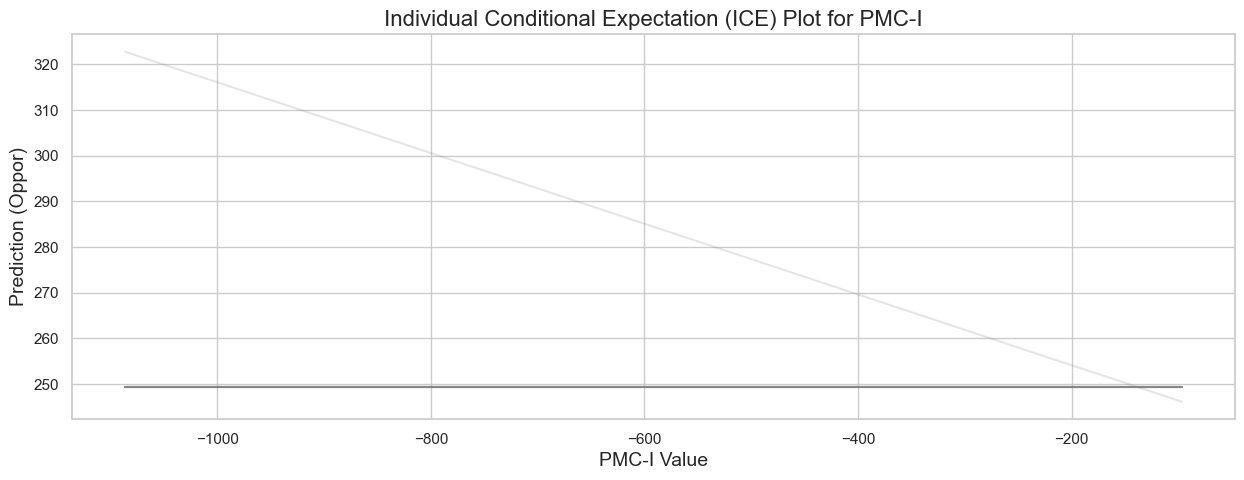

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 定义个体条件期望（ICE）函数
def ice(model, feature_idx, feature_values, dataset):
    ice_predictions = []
    for i in range(dataset.shape[0]):
        individual_predictions = []
        for value in feature_values:
            modified_dataset = dataset.copy()
            modified_dataset.iloc[i, feature_idx] = value
            predict = model.predict(modified_dataset)
            individual_predictions.append(predict[0, 1])  # 针对 'Oppor' 输出
        ice_predictions.append(individual_predictions)
    return np.array(ice_predictions)

# 假设PMC-I是数据集中的第6个特征
feature_index_ice = X_test_opp_peak.columns.get_loc('PMC-I')

# 获取PMC-I特征的值范围
feature_values_ice = np.linspace(X_test_opp_peak.iloc[:, feature_index_ice].min(), X_test_opp_peak.iloc[:, feature_index_ice].max(), num=100)

# 计算个体条件期望（ICE）
ice_predictions = ice(bpnn_model, feature_index_ice, feature_values_ice, X_test_opp_peak)

# 绘制个体条件期望（ICE）图
plt.figure(figsize=(15, 5))
for i in range(len(ice_predictions)):
    plt.plot(feature_values_ice, ice_predictions[i], color='grey', alpha=0.2)
plt.xlabel('PMC-I Value', fontsize=14)
plt.ylabel('Prediction (Oppor)', fontsize=14)
plt.title('Individual Conditional Expectation (ICE) Plot for PMC-I', fontsize=16)
plt.grid(True)
plt.show()



1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 20ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - ETA: 0s

C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 25ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 21ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 23ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 20ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 21ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 22ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 20ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 20ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - ETA: 0s

C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 20ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 24ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


1/1 [==============================] - 0s 23ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 23ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - ETA: 0s

C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the o

1/1 [==============================] - 0s 23ms/step


C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx1] = value1
C:\Users\Eric\AppData\Local\Temp\ipykernel_25992\929848144.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  modified_dataset.iloc[:, feature_idx2] = value2


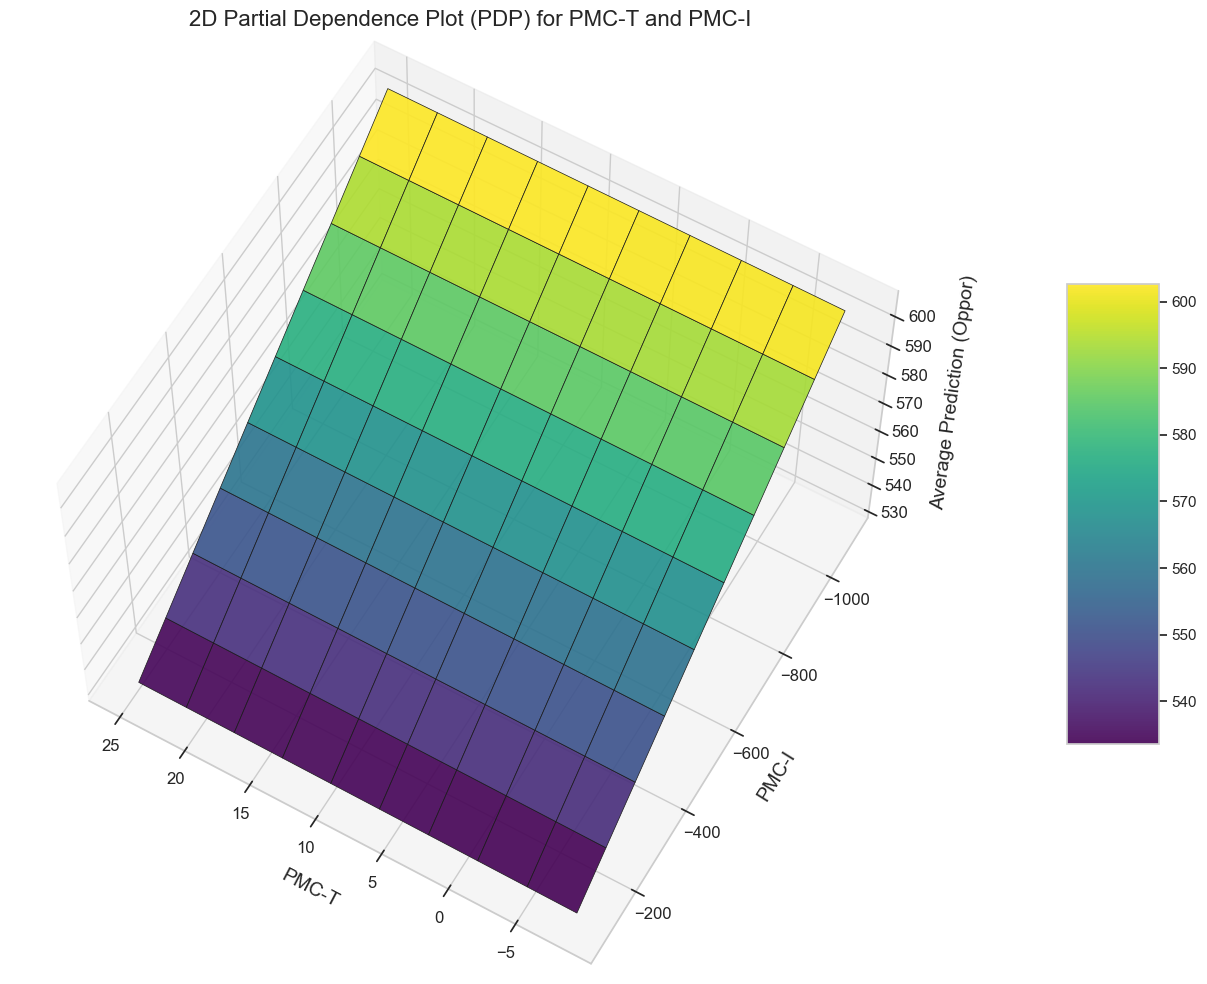

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 定义二维部分依赖函数
def partial_dependence_2d(model, feature_idx1, feature_idx2, feature_values1, feature_values2, dataset):
    predictions = np.zeros((len(feature_values1), len(feature_values2)))
    for i, value1 in enumerate(feature_values1):
        for j, value2 in enumerate(feature_values2):
            modified_dataset = dataset.copy()
            modified_dataset.iloc[:, feature_idx1] = value1
            modified_dataset.iloc[:, feature_idx2] = value2
            predict = model.predict(modified_dataset)
            predictions[i, j] = np.mean(predict[:, 1])  # 针对 'Oppor' 输出
    return predictions

# 选择要绘制二维部分依赖图的特征索引和范围
feature_index1 = X_test_opp_peak.columns.get_loc('PMC-T')
feature_index2 = X_test_opp_peak.columns.get_loc('PMC-I')
feature_values1 = np.linspace(X_test_opp_peak.iloc[:, feature_index1].min(), X_test_opp_peak.iloc[:, feature_index1].max(), num=10)
feature_values2 = np.linspace(X_test_opp_peak.iloc[:, feature_index2].min(), X_test_opp_peak.iloc[:, feature_index2].max(), num=10)

# 计算二维部分依赖
predictions_2d_pdp = partial_dependence_2d(bpnn_model, feature_index1, feature_index2, feature_values1, feature_values2, X_test_opp_peak)

# 绘制二维部分依赖图（2D PDP）
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# 创建网格
X, Y = np.meshgrid(feature_values1, feature_values2)
surf = ax.plot_surface(X, Y, predictions_2d_pdp.T, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.9)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
ax.set_xlabel('PMC-T', fontsize=14, labelpad=10)
ax.set_ylabel('PMC-I', fontsize=14, labelpad=10)
ax.set_zlabel('Average Prediction (Oppor)', fontsize=14, labelpad=10)
ax.set_title('2D Partial Dependence Plot (PDP) for PMC-T and PMC-I', fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)

# 设置视角
ax.view_init(elev=60, azim=120)
plt.tight_layout()
plt.show()


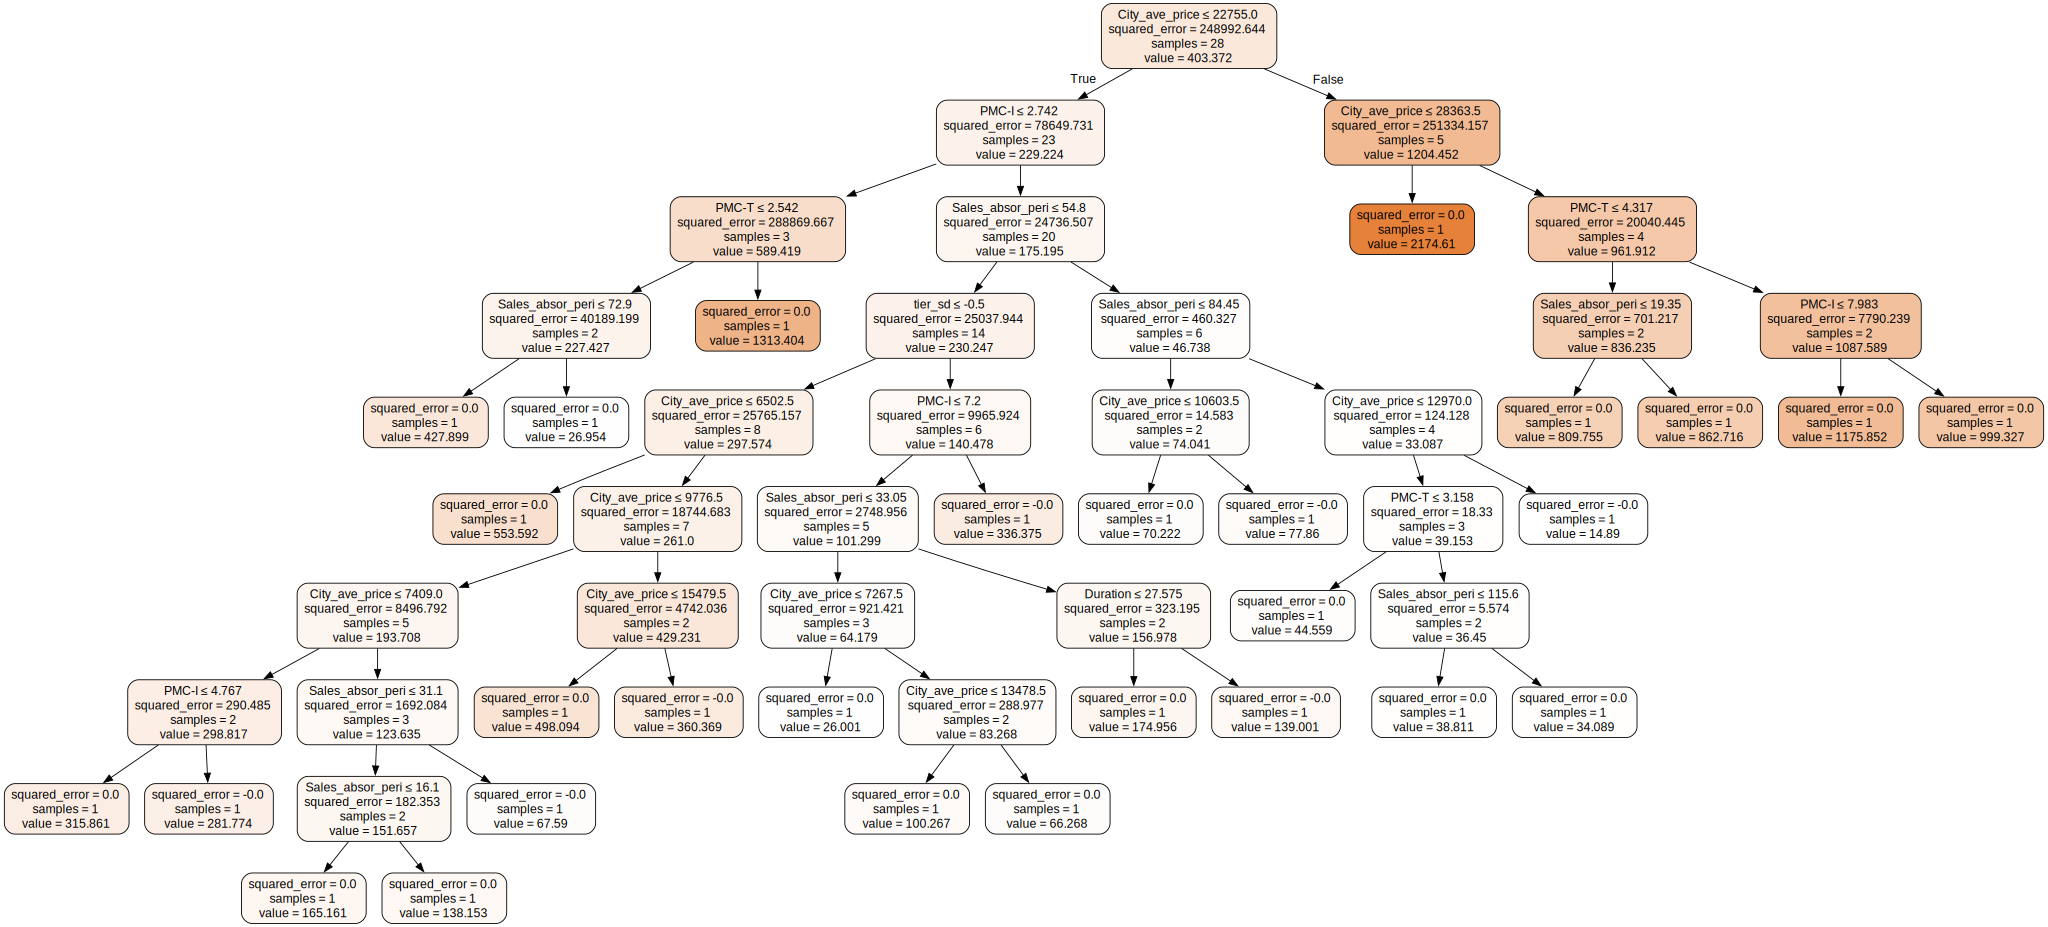

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import graphviz

# 假设你的数据集为 Neural_data
# 选择特征和目标变量
X = Neural_data[['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd', 'PMC-T', 'PMC-I']]
y = Neural_data['Oppor']  # 假设我们预测 'Oppor'

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练决策树模型
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# 定义特征名称
feature_names = ['City_ave_price', 'Sales_absor_peri', 'Duration', 'tier_sd', 'PMC-T', 'PMC-I']

# 导出并可视化决策树
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names, filled=True, rounded=True, special_characters=True)
graphviz.Source(tree_graph)
